In [ ]:
!pip install scikit-learn


     |████████████████████████████████| 11.1 MB 725 kB/s eta 0:00:01


In [ ]:
!pip install matplotlib


     |████████████████████████████    | 6.8 MB 701 kB/s eta 0:00:02

In [5]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

import time
import matplotlib.pyplot as plt


Matplotlib is building the font cache; this may take a moment.


In [7]:
# === ЗАГРУЗКА ЭМБЕДДИНГОВ ИЗ ЛР2 ===

emb_df = pd.read_csv("test_embeddings_w2v.tsv", sep="\t", header=None)

print(emb_df.shape)
emb_df.head()


(7600, 101)


,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,0,-0.118314,0.047288,-0.007946,0.019771,-0.219229,-0.210758,0.262521,0.185682,-0.263662,...,0.337087,0.401150,0.216916,-0.095150,0.356761,0.243467,0.169616,-0.077012,0.151815,0.075442
1,1,-0.293920,0.008693,-0.384293,0.259103,-0.301919,0.110242,0.233363,0.473538,-0.402907,...,0.031190,0.656488,0.219893,-0.060560,0.643895,0.234370,0.151912,-0.062119,0.058800,0.299841
2,2,-0.083807,0.063791,-0.025005,0.047651,-0.137781,-0.221276,0.018164,0.357969,-0.232443,...,0.130092,0.097922,0.359368,-0.116439,0.368216,0.148589,0.062896,-0.091088,0.111705,0.042261
3,3,-0.023368,0.047507,-0.027297,0.080789,-0.224838,-0.266854,0.093676,0.312576,-0.325746,...,0.126700,0.069655,0.216746,-0.092077,0.427910,0.139765,0.066303,-0.044586,0.116629,0.076901
4,4,-0.103390,0.042449,0.078966,0.175445,-0.093032,-0.126110,0.105943,0.348096,-0.268254,...,0.228219,0.103142,0.295814,-0.091980,0.433981,0.121597,0.040363,-0.096555,0.114375,0.199981


In [9]:
# Загружаем эмбеддинги
emb_df = pd.read_csv("test_embeddings_w2v.tsv", sep="\t", header=None)

# Загружаем метки
test_df = pd.read_csv("projects/ms-pynko/assets/dataset/news_test.csv", header=None)

# Эмбеддинги = колонки 1..100
X = emb_df.iloc[:, 1:].values

# Метки = первая колонка test_df
y = test_df.iloc[:, 0].values

print("X:", X.shape)
print("y:", y.shape)


X: (7600, 100)
y: (7600,)


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("train:", X_train.shape, y_train.shape)
print("test :", X_test.shape, y_test.shape)


train: (6080, 100) (6080,)
test : (1520, 100) (1520,)


In [12]:
import numpy as np

def compute_confusion(y_true, y_pred):
    labels = np.unique(np.concatenate([y_true, y_pred]))
    label_to_idx = {lab: i for i, lab in enumerate(labels)}
    K = len(labels)
    cm = np.zeros((K, K), dtype=int)
    for yt, yp in zip(y_true, y_pred):
        i = label_to_idx[yt]
        j = label_to_idx[yp]
        cm[i, j] += 1
    return cm, labels


def compute_metrics(y_true, y_pred):
    cm, labels = compute_confusion(y_true, y_pred)
    K = len(labels)

    total = cm.sum()
    correct = np.trace(cm)
    accuracy = correct / total
    error_rate = 1.0 - accuracy

    TP = np.trace(cm)
    FP = cm.sum(axis=0) - np.diag(cm)
    FN = cm.sum(axis=1) - np.diag(cm)

    micro_precision = TP / (TP + FP.sum() + 1e-12)
    micro_recall = TP / (TP + FN.sum() + 1e-12)
    micro_f1 = 2 * micro_precision * micro_recall / (micro_precision + micro_recall + 1e-12)

    precisions = []
    recalls = []
    f1s = []

    for i in range(K):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp

        prec = tp / (tp + fp + 1e-12)
        rec = tp / (tp + fn + 1e-12)
        f1 = 2 * prec * rec / (prec + rec + 1e-12)

        precisions.append(prec)
        recalls.append(rec)
        f1s.append(f1)

    macro_precision = float(np.mean(precisions))
    macro_recall = float(np.mean(recalls))
    macro_f1 = float(np.mean(f1s))

    return {
        "accuracy": float(accuracy),
        "error_rate": float(error_rate),
        "micro_f1": float(micro_f1),
        "macro_f1": float(macro_f1),
        "macro_precision": float(macro_precision),
        "macro_recall": float(macro_recall),
    }


In [13]:
from sklearn.svm import SVC
import time

def train_and_evaluate_svm(
    X_train, y_train, X_test, y_test,
    kernel="linear", C=1.0, gamma="scale", max_iter=2000
):
    clf = SVC(
        kernel=kernel,
        C=C,
        gamma=gamma,
        max_iter=max_iter,
        decision_function_shape="ovr"
    )

    start_time = time.time()
    clf.fit(X_train, y_train)
    train_time = time.time() - start_time

    y_pred = clf.predict(X_test)
    metrics = compute_metrics(y_test, y_pred)
    metrics["train_time"] = train_time
    metrics["kernel"] = kernel
    metrics["max_iter"] = max_iter

    return clf, metrics


In [14]:
results = []

kernels = ["linear", "rbf"]      # при желании добавь "poly"
iters_list = [500, 2000, 5000]

for kernel in kernels:
    for iters in iters_list:
        print(f"=== kernel={kernel}, max_iter={iters} ===")
        clf, m = train_and_evaluate_svm(
            X_train, y_train, X_test, y_test,
            kernel=kernel,
            max_iter=iters
        )
        results.append(m)

df_results = pd.DataFrame(results)
df_results


=== kernel=linear, max_iter=500 ===


/Users/maksim/Документы/jupiter/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


=== kernel=linear, max_iter=2000 ===


/Users/maksim/Документы/jupiter/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


=== kernel=linear, max_iter=5000 ===
=== kernel=rbf, max_iter=500 ===


/Users/maksim/Документы/jupiter/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


=== kernel=rbf, max_iter=2000 ===
=== kernel=rbf, max_iter=5000 ===


,accuracy,error_rate,micro_f1,macro_f1,macro_precision,macro_recall,train_time,kernel,max_iter
0,0.840789,0.159211,0.840789,0.838206,0.844462,0.840789,0.332648,linear,500
1,0.865132,0.134868,0.865132,0.864649,0.864776,0.865132,0.324469,linear,2000
2,0.865132,0.134868,0.865132,0.864649,0.864776,0.865132,0.318629,linear,5000
3,0.865789,0.134211,0.865789,0.865035,0.865852,0.865789,0.334121,rbf,500
4,0.868421,0.131579,0.868421,0.867925,0.867905,0.868421,0.372213,rbf,2000
5,0.868421,0.131579,0.868421,0.867925,0.867905,0.868421,0.365026,rbf,5000


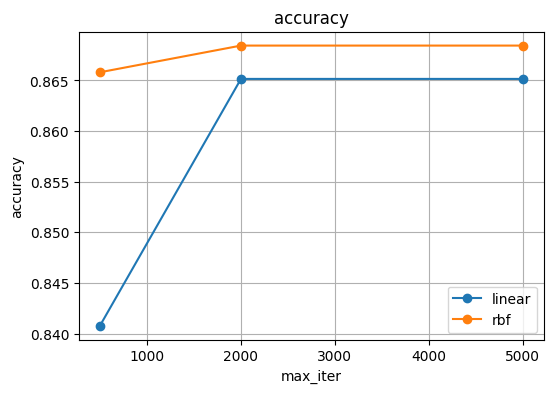

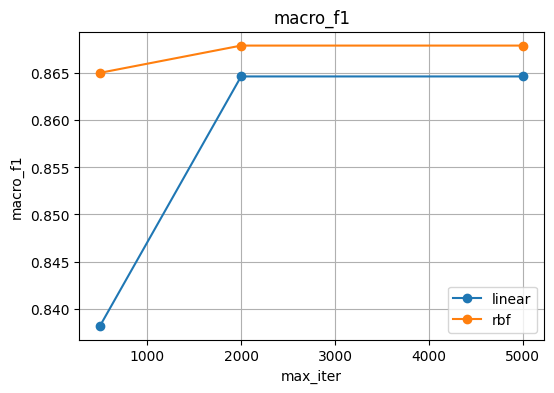

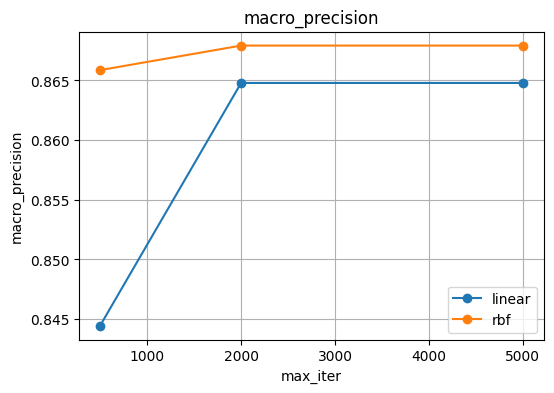

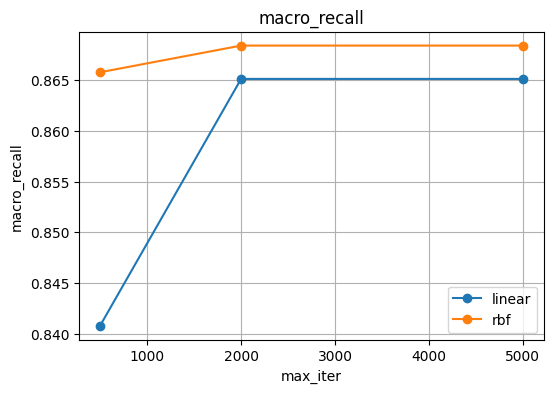

In [15]:
metrics_to_plot = ["accuracy", "macro_f1", "macro_precision", "macro_recall"]

for metric in metrics_to_plot:
    plt.figure(figsize=(6,4))
    for kernel in kernels:
        subset = df_results[df_results["kernel"] == kernel]
        plt.plot(subset["max_iter"], subset[metric], marker="o", label=kernel)
    plt.xlabel("max_iter")
    plt.ylabel(metric)
    plt.title(metric)
    plt.legend()
    plt.grid(True)
    plt.show()


In [16]:
best = df_results.sort_values("macro_f1", ascending=False).iloc[0]
best


accuracy           0.868421
error_rate         0.131579
micro_f1           0.868421
macro_f1           0.867925
macro_precision    0.867905
macro_recall       0.868421
train_time         0.372213
kernel                  rbf
max_iter               2000
Name: 4, dtype: object

In [17]:
# Используем найденные оптимальные гиперпараметры
best_kernel = best["kernel"]
best_max_iter = int(best["max_iter"])

np.random.seed(42)

# Будем оставлять разное число признаков
dims_to_keep = [100, 80, 60, 40, 20]

dim_results = []

for d in dims_to_keep:
    print(f"\n=== Размерность {d} ===")
    
    # случайно выбираем d столбцов из 100
    idx = np.random.choice(X_train.shape[1], size=d, replace=False)
    
    X_train_sub = X_train[:, idx]
    X_test_sub  = X_test[:, idx]
    
    _, m = train_and_evaluate_svm(
        X_train_sub, y_train,
        X_test_sub,  y_test,
        kernel=best_kernel,
        max_iter=best_max_iter
    )
    m["dim"] = d
    dim_results.append(m)

df_dim = pd.DataFrame(dim_results).sort_values("dim", ascending=False)
df_dim



=== Размерность 100 ===

=== Размерность 80 ===

=== Размерность 60 ===

=== Размерность 40 ===

=== Размерность 20 ===


,accuracy,error_rate,micro_f1,macro_f1,macro_precision,macro_recall,train_time,kernel,max_iter,dim
0,0.868421,0.131579,0.868421,0.867925,0.867905,0.868421,0.388133,rbf,2000,100
1,0.869737,0.130263,0.869737,0.869125,0.868983,0.869737,0.361301,rbf,2000,80
2,0.864474,0.135526,0.864474,0.863829,0.863650,0.864474,0.327415,rbf,2000,60
3,0.851974,0.148026,0.851974,0.851570,0.851548,0.851974,0.235359,rbf,2000,40
4,0.785526,0.214474,0.785526,0.784747,0.784894,0.785526,0.310866,rbf,2000,20


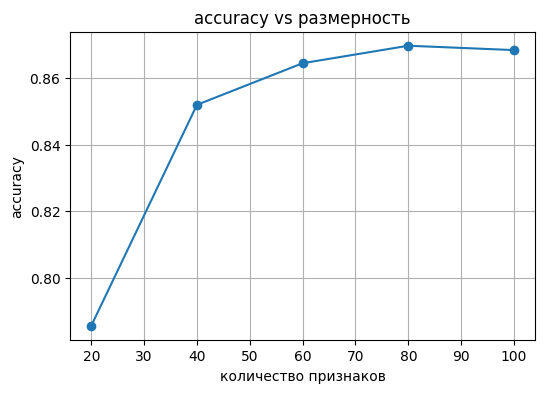

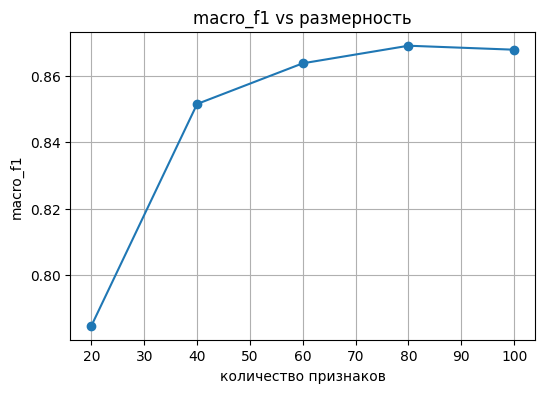

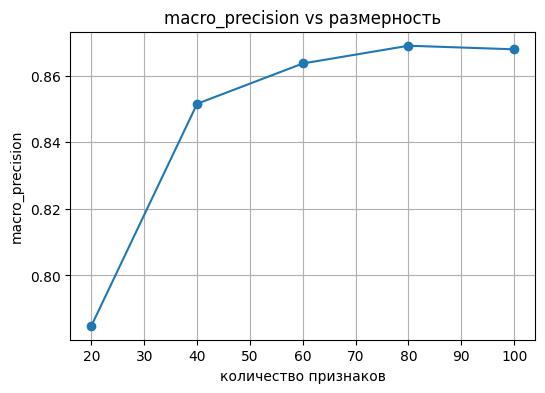

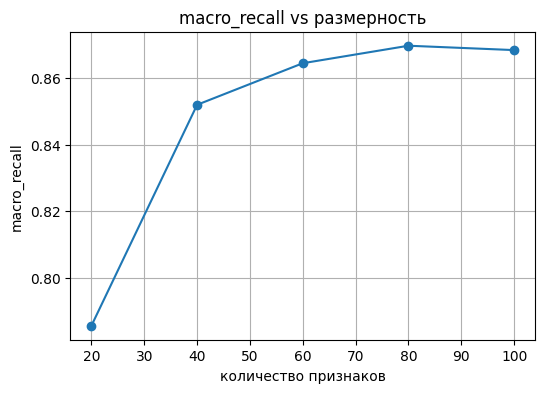

In [18]:
metrics_to_plot = ["accuracy", "macro_f1", "macro_precision", "macro_recall"]

for metric in metrics_to_plot:
    plt.figure(figsize=(6,4))
    plt.plot(df_dim["dim"], df_dim[metric], marker="o")
    plt.xlabel("количество признаков")
    plt.ylabel(metric)
    plt.title(f"{metric} vs размерность")
    plt.grid(True)
    plt.show()


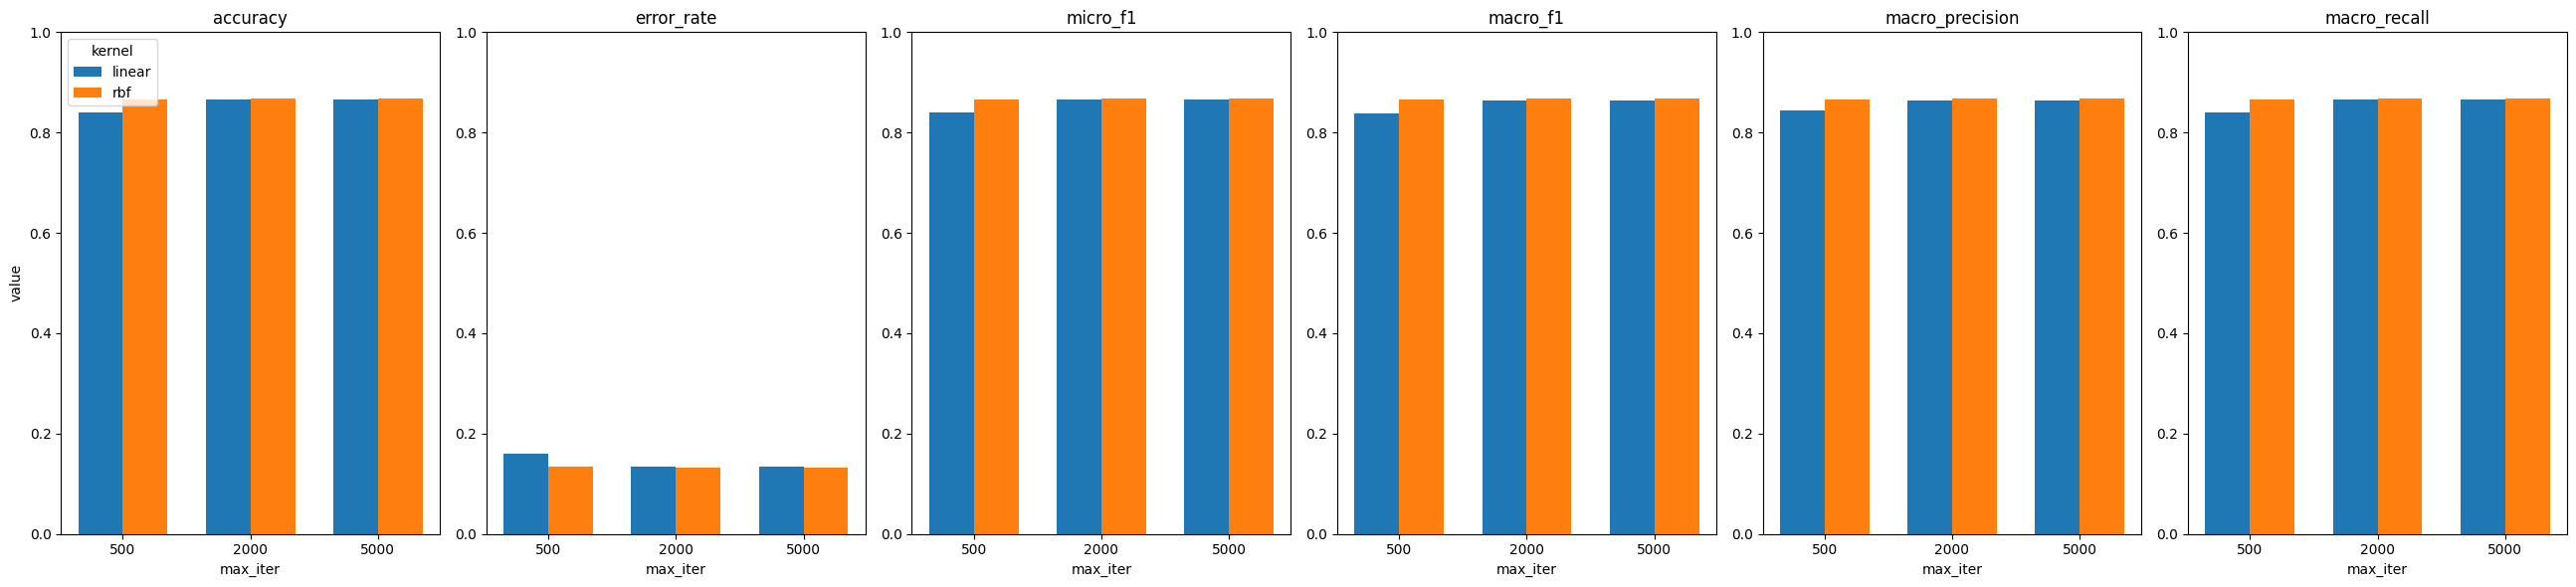

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# копия таблицы
df = df_results.copy()

# приведение типов
df["max_iter"] = df["max_iter"].astype(int)

metrics = ["accuracy", "error_rate", "micro_f1", "macro_f1", "macro_precision", "macro_recall"]
kernels = df["kernel"].unique()
iters = sorted(df["max_iter"].unique())

# ширина бара
bar_width = 0.35

# строим рисунок
fig, axes = plt.subplots(1, len(metrics), figsize=(26, 6))

for i, metric in enumerate(metrics):
    ax = axes[i]

    x = np.arange(len(iters))  # позиции по оси X
    
    for j, kernel in enumerate(kernels):
        subset = df[df["kernel"] == kernel].sort_values("max_iter")

        ax.bar(
            x + j * bar_width,
            subset[metric],
            width=bar_width,
            label=kernel if i == 0 else None
        )

    ax.set_title(metric)
    ax.set_xticks(x + bar_width / 2)
    ax.set_xticklabels(iters)
    ax.set_xlabel("max_iter")
    ax.set_ylim(0, 1)

axes[0].set_ylabel("value")
axes[0].legend(title="kernel")

plt.tight_layout()
plt.show()


In [21]:
df_results_sorted = df_results.sort_values(["kernel", "max_iter"])
df_results_sorted


,accuracy,error_rate,micro_f1,macro_f1,macro_precision,macro_recall,train_time,kernel,max_iter
0,0.840789,0.159211,0.840789,0.838206,0.844462,0.840789,0.332648,linear,500
1,0.865132,0.134868,0.865132,0.864649,0.864776,0.865132,0.324469,linear,2000
2,0.865132,0.134868,0.865132,0.864649,0.864776,0.865132,0.318629,linear,5000
3,0.865789,0.134211,0.865789,0.865035,0.865852,0.865789,0.334121,rbf,500
4,0.868421,0.131579,0.868421,0.867925,0.867905,0.868421,0.372213,rbf,2000
5,0.868421,0.131579,0.868421,0.867925,0.867905,0.868421,0.365026,rbf,5000


In [22]:
df_report = df_results_sorted.copy()
for col in ["accuracy", "error_rate", "micro_f1", "macro_f1", "macro_precision", "macro_recall"]:
    df_report[col] = df_report[col].round(4)

df_report


,accuracy,error_rate,micro_f1,macro_f1,macro_precision,macro_recall,train_time,kernel,max_iter
0,0.8408,0.1592,0.8408,0.8382,0.8445,0.8408,0.332648,linear,500
1,0.8651,0.1349,0.8651,0.8646,0.8648,0.8651,0.324469,linear,2000
2,0.8651,0.1349,0.8651,0.8646,0.8648,0.8651,0.318629,linear,5000
3,0.8658,0.1342,0.8658,0.8650,0.8659,0.8658,0.334121,rbf,500
4,0.8684,0.1316,0.8684,0.8679,0.8679,0.8684,0.372213,rbf,2000
5,0.8684,0.1316,0.8684,0.8679,0.8679,0.8684,0.365026,rbf,5000
